## Analysis of modified Cox-Ingersoll-Ross model via moment bounding schemes

Beyond jump processes modeling stochastic chemical systems, a much wider range of stochastic processes admits computable bounds on stationary and transient moments and related statistics via convex optimization. Generally all jump-diffusion processes of the form
$$
    dx = f(x) \, dt + g(x) \, dW_t + \sum_{i=1}^n h_i(x) \, dN_{a_i(x),t}
$$
can be analyzed as long as the data:
        $f$ - drift coefficient
        $gg^\top$ - diffusion matrix
        $h_i$ - jumps
        $a_i$ - arrival rates
are polynomials and the state space of the system is basic closed semialgebraic (i.e., described by finitely many polynomial inequalities) or can at least be reasonably well approximated by a basic closed semialgebraic set. In the following, we show with an example how to set the bounding problems up and compute relevant statistics.

Let us consider the simple Cox-Ingersoll-Ross (CIR) model for the dynamics of interest rates
$$    
    dx =  \kappa(\theta-x) \, dt + \sigma \sqrt{x} \, dW_t
$$
As can be seen from the model this is a pure diffusion process. Such a process is defined as follows:

In [1]:
using MarkovBounds, Plots, MosekTools
κ, θ, σ = 0.15, 0.03, 0.05 # model parameters
@polyvar(x) # states (interest rate)
f = κ*(θ-x) # drift coefficient
g = σ^2*x   # diffusion matrix (outer product )
X = @set(x >= 0) # support/state space

solver = optimizer_with_attributes(Mosek.Optimizer, "LOG" => 0)
cir = DiffusionProcess(x, f, g, X)

Diffusion Process
-----------------------
  States: [x]
  Drift: [0.0045 - 0.15x]
  Diffusion: [0.0025000000000000005x;;]
  State space: { (x) | x ≥ 0 }


With the diffusion process defined, we can bound interesting quantities such as the long term average or variance of the interest rate x simply by calling

In [2]:
mean = stationary_mean(cir, x, 2, solver);
println("True stationary mean of interest rate lies in [$(mean[1].value), $(mean[2].value)]")
var = stationary_variance(cir, x, 2, solver);
println("True stationary variance of interest rate lies below $(var.value)")

True stationary mean of interest rate lies in [0.03, 0.03]


True stationary variance of interest rate lies below 0.0002500090164914171


Similarly, bounds along a trajectory can be evaluated with ease. In order to showcase how also jump-diffusion are dealt with, let us assume that the interest rate drops to half of its value at random times characterized by a Poisson process with rate a(x) = 0.035 x. To define this process, we can simply define the jump component separately as a jump process:

In [3]:
a = 10*x # arrival rate
h = x/2 # jump (interest rate jumps to half its value)
jumps = JumpProcess(x, a, h, X)

Jump Process
-----------------------
  States: [x]
  Propensities: [10x]
  Jumps: [[0.5x]]
  State Space: { (x) | x ≥ 0 }


The overall jump-diffusion process is then defined in terms of the jump and diffusion process:

In [4]:
jumping_cir = JumpDiffusionProcess(jumps, cir)

Jump-Diffusion Process
-----------------------
  States: [x]
  Propensities: [10x]
  Jumps: [[0.5x]]
  Drift: [0.0045 - 0.15x]
  Diffusion: [0.0025000000000000005x;;]
  State Space: { (x) | x ≥ 0, x ≥ 0 }


Alternatively the process could also be defined in terms of the whole set of problem data:

``cir_jump = JumpDiffusionProcess(x, a, h, f, g, X)``
    
Now we can for example study the evolution of means and variances of this process over time:

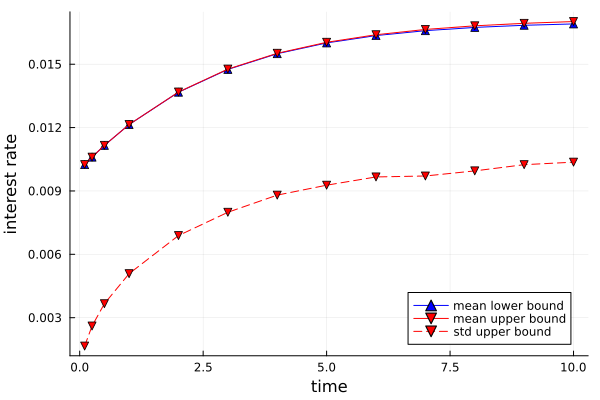

In [5]:
Ts = [0.1, 0.25, 0.5, 1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10] # time points to probe mean and variance at
x0 = 0.01 # initial condition (deterministic - assumed)
order = 4 # relaxation order used
nT = 10 # number of time intervals used to discretize the time domain
μ0 = Dict(x^i => x0^i for i in 0:order+1) # moments of the initial distribution
var_bounds, mean_bounds = [], []
for T in Ts
    trange = range(0, T, length = nT + 1)
    mean = transient_mean(jumping_cir, μ0, x, order, trange, solver)
    push!(mean_bounds, mean)
    var = transient_variance(jumping_cir, μ0, x, order, trange, solver)
    push!(var_bounds, var)
end
p = plot(xlabel="time", ylabel="interest rate", legend=:bottomright)
plot!(p, Ts, [b[1].value for b in mean_bounds], marker = :^, color=:blue, label="mean lower bound")
plot!(p, Ts, [b[2].value for b in mean_bounds], marker = :v, color=:red, label="mean upper bound")
plot!(p, Ts, sqrt.([var.value for var in var_bounds]), marker = :v, color=:red, linestyle=:dash, label="std upper bound")
display(p)

In case we care more about long term predictions of the interest rate, we may wanna study the stationary mean and variance of the interest rate

In [6]:
mean = stationary_mean(jumping_cir, x, 4, solver);
println("True stationary mean of interest rate lies in [$(mean[1].value), $(mean[2].value)]")
var = stationary_variance(jumping_cir, x, 4, solver);
println("True stationary variance of interest rate lies below $(var.value)")

True stationary mean of interest rate lies in [0.017129044654811163, 0.01717980050571739]


True stationary variance of interest rate lies below 9.274030933389941e-5
